In [ ]:
!pip install wandb
!pip install transformers

In [ ]:
import os
import pdb
import pandas as pd
import wandb
import argparse
import nltk
from collections import Counter
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence


import re
import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

In [ ]:
# \n 포함되어 처리 됨, 공백 제거, 마침표 제거, Task 필요하지 않음
def make_id_file(swords = False):
    if swords == True:
      from nltk.corpus import stopwords
      nltk.download('stopwords')
    def make_data_strings(file_name, swords = swords):
        data_strings = []
        pattern = '[\r|\n]'
        with open(os.path.join('./goorm', file_name), 'r', encoding='utf-8') as f:
            id_file_data = [line.lower() for line in f.readlines()]
        for item in id_file_data:
            texts = ''.join([str(k) for k in item])
            # Remove punctuation
            texts = re.sub(r'_num_', " ", texts)
            texts = re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", texts)
            texts = re.sub(pattern=pattern, repl='', string=texts).rstrip().split()

            if swords == True:
              stop = stopwords.words('english')
              texts = [text for text in texts if text not in stop]
            data_strings.append(' '.join(texts))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1', swords)
    train_neg = make_data_strings('sentiment.train.0', swords)
    dev_pos = make_data_strings('sentiment.dev.1', swords)
    dev_neg = make_data_strings('sentiment.dev.0', swords)

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file(swords = True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
it will take some times...
make id file finished!


In [ ]:
train_pos[:10]

['excellent food',
 'superb customer service',
 'also daily specials ice cream really good',
 'good toasted hoagie',
 'staff friendly',
 'good bar food',
 'good service',
 'soup day homemade lots specials',
 'great place lunch bar snacks beer',
 'new range looks amazing']

In [ ]:
df_train_pos = pd.DataFrame({'data': train_pos, 'label': 1})
df_train_neg = pd.DataFrame({'data': train_neg, 'label': 0})
df_train = pd.concat([df_train_pos,df_train_neg])
df_train['length'] = df_train['data'].apply(len)

df_test_pos = pd.DataFrame({'data': dev_pos, 'label': 1})
df_test_neg = pd.DataFrame({'data': dev_neg, 'label': 0})
df_test = pd.concat([df_test_pos,df_test_neg])
df_test['length'] = df_test['data'].apply(len)
df = pd.concat([df_train,df_test])

In [ ]:
df

,data,label,length
0,excellent food,1,14
1,superb customer service,1,23
2,also daily specials ice cream really good,1,41
3,good toasted hoagie,1,19
4,staff friendly,1,14
...,...,...,...
1995,sad see much place gone downhill,0,32
1996,food n good,0,11
1997,n quite years,0,13
1998,service last time went terrible,0,31


전체 데이터셋의 크기: 447259

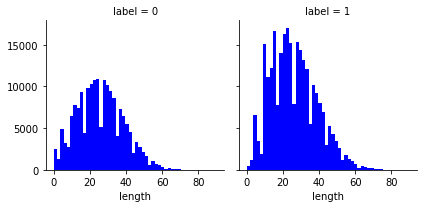

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')

In [ ]:
#Null 데이터 확인
df.isnull().sum()

data      0
label     0
length    0
dtype: int64

In [ ]:
#아무것도 포함되지 않은 행렬 확인, 제거
print(df.loc[df['length'] <= 1])
none_idx = df.loc[df['length'] <= 1].index
df = df.drop(none_idx)

     data  label  length
614     )      1       1
1301           1       0
1759    )      1       1
1942    )      1       1
2233    )      1       1
...   ...    ...     ...
1893           0       0
1894           0       0
1896           0       0
1897           0       0
1898           0       0

[2885 rows x 3 columns]


In [ ]:
print(df.loc[df['length'] <= 1])

Empty DataFrame
Columns: [data, label, length]
Index: []


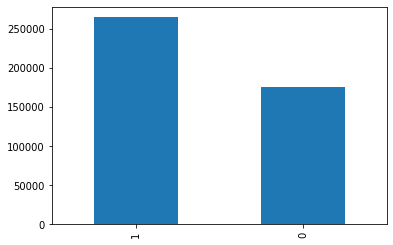

In [ ]:
# 긍부정 리뷰 갯수 파악
df['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(df.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0  176398
1      1  265080


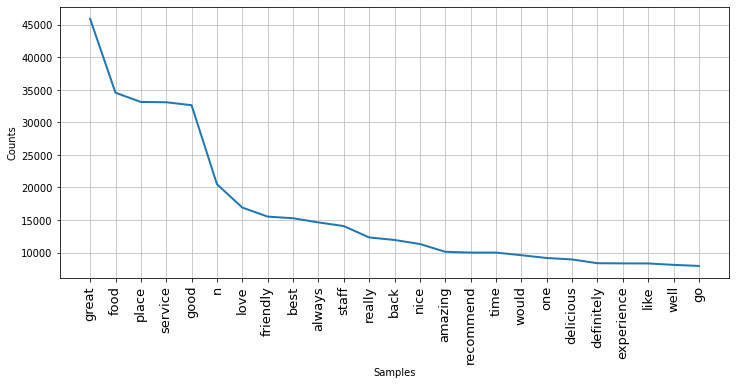

In [ ]:
# most common words in twitter dataset 
all_texts = []
for line in list(df['data']):
    texts = line.split()
    for text in texts:
        all_texts.append(text)
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_texts)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_texts).values(), reverse=True)

In [ ]:
import gensim
from urllib.request import urlretrieve, urlopen
urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [ ]:
print(word2vec_model['this'])

[ 0.109375    0.140625   -0.03173828  0.16601562 -0.07128906  0.01586914
 -0.00311279 -0.08496094 -0.04858398  0.05566406 -0.08251953 -0.02404785
 -0.00665283  0.03686523 -0.05029297 -0.02941895  0.11376953 -0.06787109
  0.05639648 -0.07568359 -0.03857422  0.09716797 -0.04418945 -0.12207031
  0.140625    0.08496094  0.09667969  0.07470703 -0.0039978   0.17285156
 -0.06933594  0.08886719  0.03808594 -0.00061417  0.01184082  0.00164032
 -0.20898438 -0.08251953  0.08984375  0.07910156  0.12353516 -0.01867676
  0.03039551  0.04711914  0.06542969 -0.01251221  0.00152588  0.10644531
 -0.01531982 -0.04199219  0.16796875  0.05175781  0.07470703  0.08251953
  0.01721191  0.01599121  0.02734375 -0.03686523  0.08105469 -0.06445312
 -0.08984375  0.10742188  0.01153564 -0.13671875  0.05151367 -0.02429199
  0.02282715  0.12353516  0.01531982  0.1484375   0.02441406 -0.0625
  0.08154297 -0.06494141  0.02038574  0.05126953  0.125       0.09765625
  0.05810547  0.18652344  0.05834961 -0.19921875  0.020

In [ ]:
import torch.nn as nn
from torchtext.vocab import Vectors

In [ ]:
vectors = Vectors(name="GoogleNews-vectors-negative300.bin.gz")

  0%|          | 1/4672122 [00:00<3:55:43, 330.34it/s]


ValueError: ignored

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
class SentimentDataset(object):
    def __init__(self, pos, neg):
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += pos_sent
            self.label += [[1]]
        for neg_sent in neg:
            self.data += neg_sent
            self.label += [[0]]
          
        self.df = pd.DataFrame({
            'data': self.data,
            'label': self. label})

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [ ]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [ ]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([ 101, 6581, 2833, 1012,  102]), array([1]))
(array([  101, 21688,  8013,  2326,  1012,   102]), array([1]))
(array([  101,  2027,  2036,  2031,  3679, 19247,  1998,  3256,  6949,
        2029,  2003,  2428,  2204,  1012,   102]), array([1]))
(array([  101,  2009,  1005,  1055,  1037,  2204, 15174,  2098,  7570,
       22974,  2063,  1012,   102]), array([1]))
(array([ 101, 1996, 3095, 2003, 5379, 1012,  102]), array([1]))
(array([ 101, 2204, 3347, 2833, 1012,  102]), array([1]))
(array([ 101, 2204, 2326, 1012,  102]), array([1]))
(array([  101, 11350,  1997,  2154,  2003, 25628,  1998,  7167,  1997,
       19247,  1012,   102]), array([1]))
(array([  101,  2307,  2173,  2005,  6265,  2030,  3347, 27962,  1998,
        5404,  1012,   102]), array([1]))
(array([ 101, 1996, 2047, 2846, 3504, 6429, 1012,  102]), array([1]))
(array([ 101, 2023, 2173, 2001, 2200, 2204, 1012,  102]), array([1]))


In [ ]:
def collate_fn_sentiment(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [ ]:
train_batch_size=64
eval_batch_size=64

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_sentiment,
                                           pin_memory=True, num_workers=4)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=False, collate_fn=collate_fn_sentiment,
                                         num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [ ]:
train_epoch = 1
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            if iteration != 0 and iteration % int(len(train_loader) / 5) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        output = model(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       position_ids=position_ids,
                                       labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)
                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)

  0%|          | 0/6926 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 0:  20%|██        | 1386/6926 [11:15<5:45:15,  3.74s/batch, loss=0.103]

Acc for model which have lower valid loss:  0.9655


Epoch 0:  40%|████      | 2771/6926 [22:26<4:19:21,  3.75s/batch, loss=0.0232]

Acc for model which have lower valid loss:  0.97525


Epoch 0:  60%|██████    | 4156/6926 [33:38<2:54:13,  3.77s/batch, loss=0.122]

Acc for model which have lower valid loss:  0.974


Epoch 0:  80%|████████  | 5541/6926 [44:49<1:26:08,  3.73s/batch, loss=0.0155]

Acc for model which have lower valid loss:  0.9805


Epoch 0: 100%|██████████| 6926/6926 [56:00<00:00,  2.06batch/s, loss=0.00826]

Acc for model which have lower valid loss:  0.97725


In [ ]:
import pandas as pd
test_df = pd.read_csv('./goorm/test_no_label.csv')

In [ ]:
test_dataset = test_df['Id']

In [ ]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [ ]:
test = make_id_file_test(tokenizer, test_dataset)

In [ ]:
test[:10]

In [ ]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [ ]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [ ]:
def collate_fn_sentiment_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [ ]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_sentiment_test,
                                          num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        output = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids,
                       position_ids=position_ids)

        logits = output.logits
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        predictions += batch_predictions

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission.csv', index=False)